In [383]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.interpolate import CubicSpline
from copy import deepcopy

In [384]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [385]:
from probability.distributions import HistogramDistribution
from probability.transforms import histogram_transform
from probability.visualization import plot_pdf_transform

In [386]:
# Linear Belief Propogation Example

# define the domain
domain_bounds = [(-10, 10)]
bin_counts = [1000]

# define the prior
prior = HistogramDistribution(domain_bounds, bin_counts, None)
sample_points = prior.bin_midpoints
prior.pmf_values = multivariate_normal.pdf(sample_points, 0, 8)     # bins evaluated at midpoint

# define the non-linear transform
func = lambda x: 0.6 * x - 2.0

# compute the posterior
posterior = histogram_transform(func, prior, output_pdf=deepcopy(prior))

# visualize
transform_values = func(prior.domain)
plot_pdf_transform(
    prior, transform_values, posterior,
    slice_highlights=[(0.5, 1.5), (-5.5, -4.5)],
    title="Linear Uncertainty Propagation",
    prior_label=r"$p(x) = N(\mu, \Sigma)$",
    posterior_label=r"$p(y) = N(A\mu + B, A \Sigma A^\top)$",
    transform_label=r"$y = Ax + B$"
)

TypeError: clip() missing 1 required positional argument: 'a_max'

array([[<Axes: ylabel='posterior'>, <Axes: >],
       [<Axes: >, <Axes: xlabel='prior'>]], dtype=object)

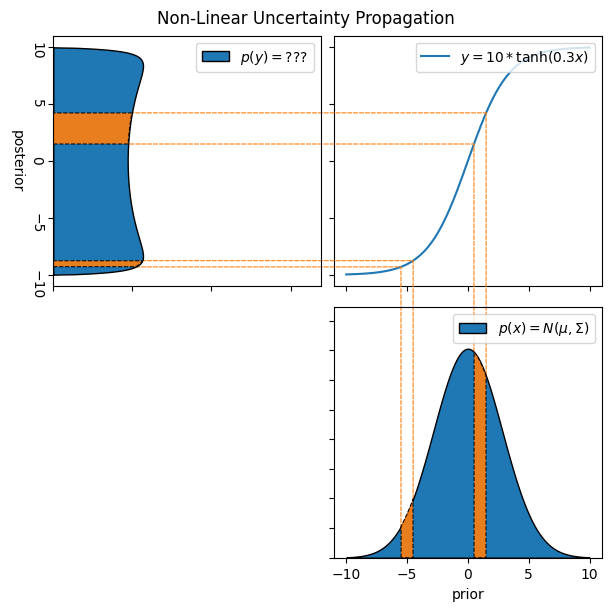

In [ ]:
# Non-Linear Belief Propogation Example

# define the domain
domain_bounds = [(-10, 10)]
bin_counts = [1000]

# define the prior
prior = HistogramDistribution(domain_bounds, bin_counts, None)
sample_points = prior.bin_midpoints
prior.pmf_values = multivariate_normal.pdf(sample_points, 0, 8)     # bins evaluated at midpoint
prior.pmf_values /= np.sum(prior.pmf_values)

# define the non-linear transform
func = lambda x: 10 * np.tanh(0.3 * x)

# compute the posterior
posterior = histogram_transform(func, prior, output_pdf=deepcopy(prior))

# visualize
transform_values = func(prior.domain)
plot_pdf_transform(
    prior, transform_values, posterior,
    slice_highlights=[(0.5, 1.5), (-5.5, -4.5)],
    title="Non-Linear Uncertainty Propagation",
    prior_label=r"$p(x) = N(\mu, \Sigma)$",
    posterior_label=r"$p(y) = ???$",
    transform_label=r"$y = 10 * \tanh(0.3x)$",
)

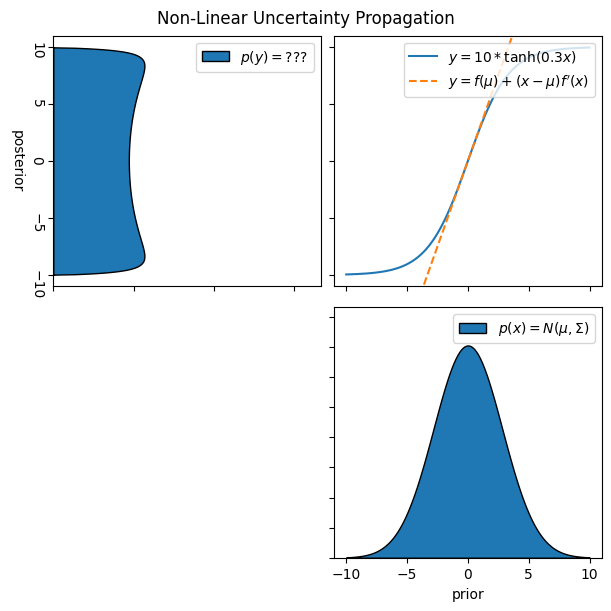

In [445]:
# Non-Linear Belief Propogation - With Linearization

from example_systems import random_smooth_function
import jax
from jax import numpy as jnp

# define the domain
domain_bounds = [(-10, 10)]
bin_counts = [1000]

# define the prior
prior = HistogramDistribution(domain_bounds, bin_counts, None)
sample_points = prior.bin_midpoints
prior.pmf_values = multivariate_normal.pdf(sample_points, 0, 8)     # bins evaluated at midpoint
prior.pmf_values /= np.sum(prior.pmf_values)

# define the non-linear transform
# func = lambda x: x + 10 * 1/x * np.sin((0.3*x)**2)
# func = lambda x: x + np.exp(-(0.8*x)**2) * -2*x
# func = lambda x: 5*np.arctan(x)
# func = random_smooth_function([(-10, 10)], [(-10, 10)])
func = lambda x: 10 * jnp.tanh(0.3 * x)

# compute the posterior
posterior = histogram_transform(func, prior, output_pdf=deepcopy(prior))

# visualize
transform_values = func(prior.domain)
axes = plot_pdf_transform(
    prior, transform_values, posterior,
    # slice_highlights=[(0.5, 1.5), (-5.5, -4.5)],
    title="Non-Linear Uncertainty Propagation",
    prior_label=r"$p(x) = N(\mu, \Sigma)$",
    posterior_label=r"$p(y) = ???$",
    transform_label=r"$y = 10 * \tanh(0.3x)$",
)

for ax in axes.ravel(): ax.autoscale(enable=False)  # freeze axis limits

# plot linear approximation
slope = jax.jacfwd(func)(0.0)
intercept = func(0)
transform_linear_approx = lambda x: intercept + slope * x
transform_linear_approx_values = transform_linear_approx(prior.domain[:,0])

axes[0, 1].plot(
    prior.domain[:,0], transform_linear_approx_values,
    linestyle="--", label=r"$y = f(\mu) + (x-\mu)f'(x)$"
)
axes[0, 1].legend(loc="upper right")